In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
import numpy as np

In [2]:
# Discards the smallest alpha% samples at every iteration
def bwgd_discard_iter(y, A, alpha, eta=1, niter=40):
    d, n = A.shape  
    x = np.zeros((niter, d))  
    x[0] = np.random.randn(d)
    threshold = int(alpha * n)

    # Descent
    for iter in range(1, niter):
        # Find indices for smallest |AtX|
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        # Discard the selected indices
        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        # Covariance matrix transform
        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered 
        x_tilde = C_sqrt @ x[iter - 1]

        # Descent
        sum_gradient = A_tilde @ (np.sqrt(y_filtered) * (A_tilde.T @ x_tilde) / np.abs(A_tilde.T @ x_tilde))
        x_tilde = (1 - eta) * x_tilde + (eta / n) * sum_gradient

        x[iter] = C_inv @ x_tilde
        
    return x

In [178]:
# Take minimum error for positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-1*x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

In [23]:
# Returns the convergence count for errors for a set of test parameters
def convergence_counts(errors, parameter):
    zero_error = {}
    for i in range(len(errors)):
        zero_error[parameter[i]] = 0
        for error in errors[i]:
            zero_error[parameter[i]] += error[-1] < 1e-11
    return zero_error

**Trajectories**

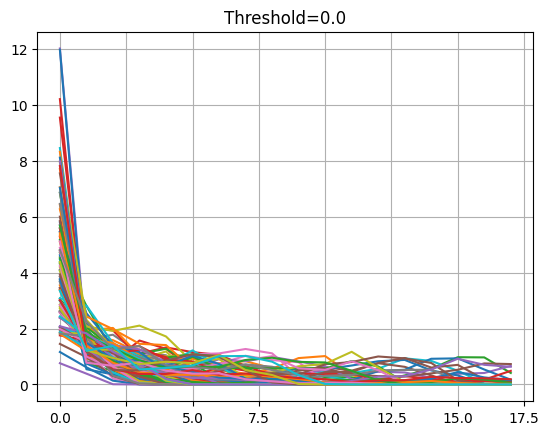

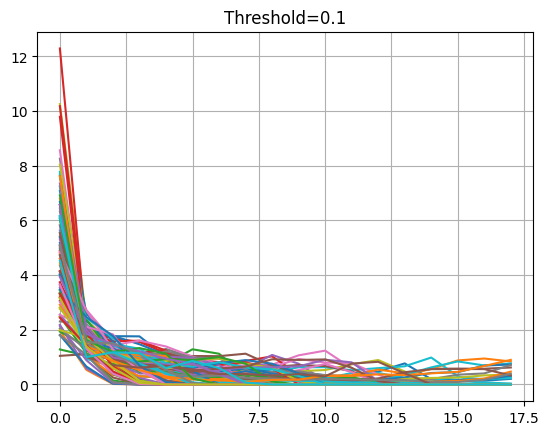

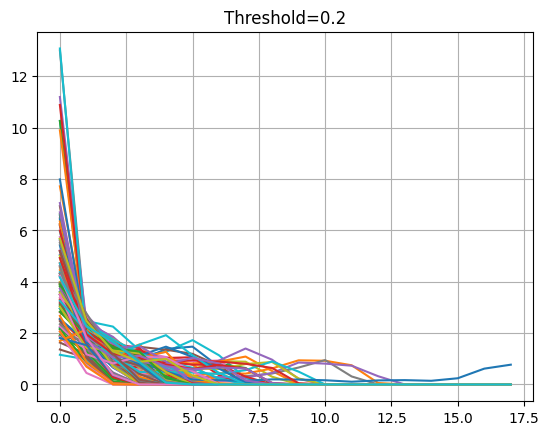

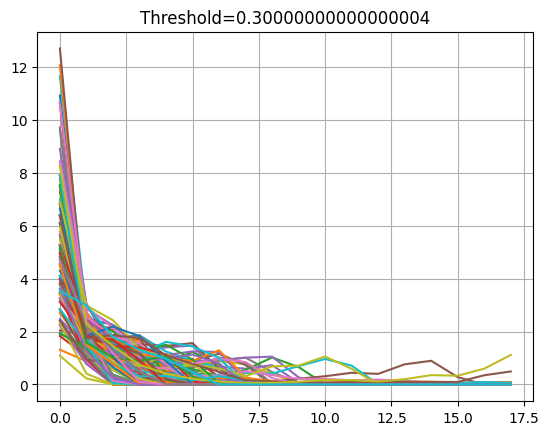

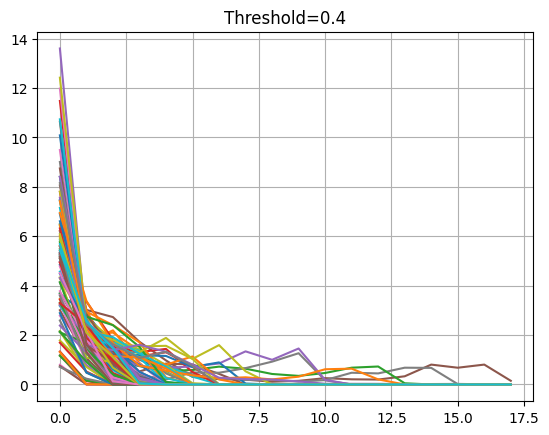

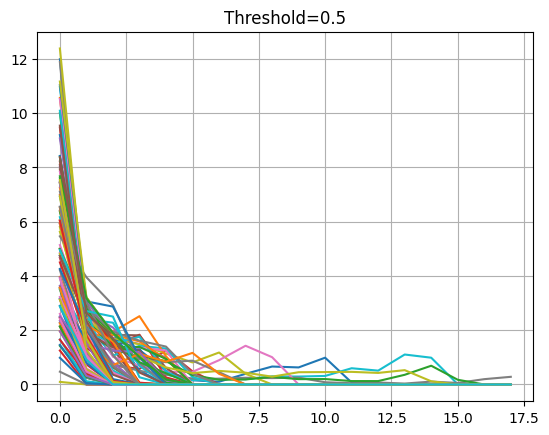

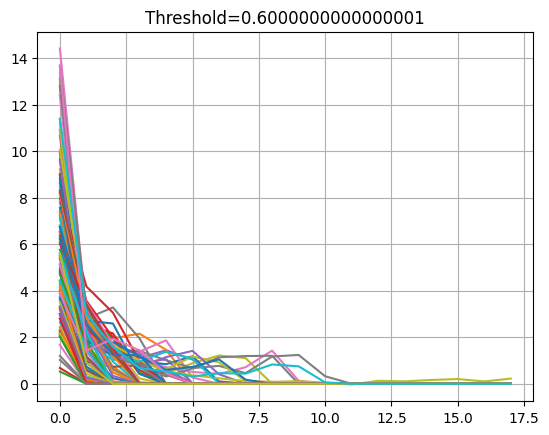

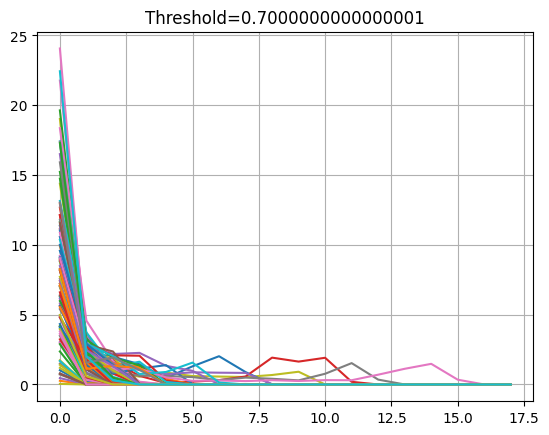

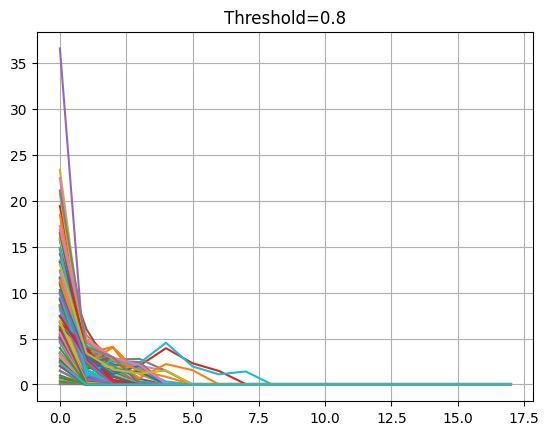

In [193]:
n = 1000
d = 50
x_true = np.ones(d)
thresholds =  np.arange(0, 9)*0.1

# Iterate through thesholds
for threshold in thresholds:
    for i in range(100):
        A = np.random.randn(d, n)
        y = np.square(A.T @ x_true)
        x = bwgd_discard_iter(y, A, threshold, niter=20)
        inner_products = []
        # Loop over iterations to compute the inner products of trajectories
        for t in range(len(x)-2):
            # Compute errors for x* and -x*
            error_pos = np.linalg.norm(x[t] - x_true)
            error_neg = np.linalg.norm(x[t] - x_true*-1)
    
            # Choose the x* with the smaller error
            if error_pos < error_neg:
                dif = x[t] - x_true 
            else:
                dif = x[t] + x_true            

            # Qt = P_ut-u*^perp
            Qt = np.eye(d) - np.outer(dif, dif) / np.linalg.norm(dif) ** 2
                
            # Compute the inner product of consecutive projected differences
            #  <Qt(ut+1 - ut), Qt(ut+2 - ut)>
            inner_product = np.dot(np.dot(Qt,x[t+1]-x[t]), np.dot(Qt,x[t+2]-x[t]))
            inner_products.append(inner_product)
        plt.plot(inner_products)

    plt.title(f'Threshold={threshold}')
    plt.grid(True)
    plt.show()
    

**Track Sample Index Set**

In [201]:
from tqdm import tqdm
# Discards the smallest alpha% samples at every iteration
def bwgd_discard_iter_test_threshold(y, A, alpha, eta=1, niter=30):
    d, n = A.shape  
    x = np.zeros((niter, d))  
    x[0] = np.random.randn(d)
    threshold = int(alpha * n)
    threshold_indices = []

    # Descent
    for iter in range(1, niter):
        # Find indices for smallest |AtX|
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        # Save the discarded indeces
        threshold_indices.append(sorted_indices[:threshold])
        
        # Discard the selected indices
        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        # Covariance matrix transform
        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered 
        x_tilde = C_sqrt @ x[iter - 1]

        # Descent
        sum_gradient = A_tilde @ (np.sqrt(y_filtered) * (A_tilde.T @ x_tilde) / np.abs(A_tilde.T @ x_tilde))
        x_tilde = (1 - eta) * x_tilde + (eta / n) * sum_gradient

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1])<1e-11:
            return x[:iter], threshold_indices
        
    return x, threshold_indices

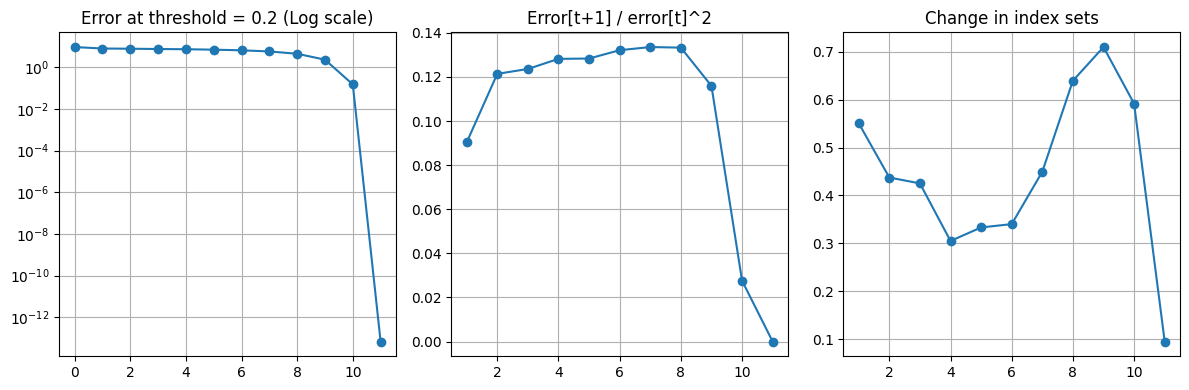

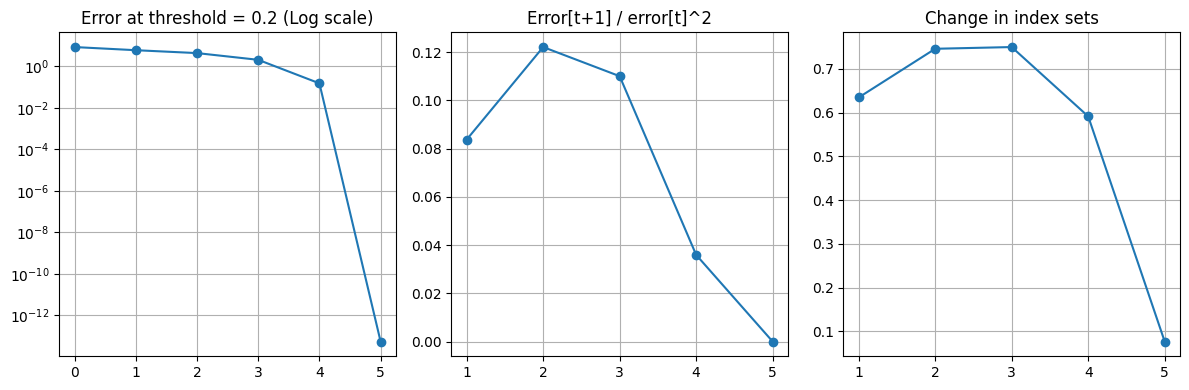

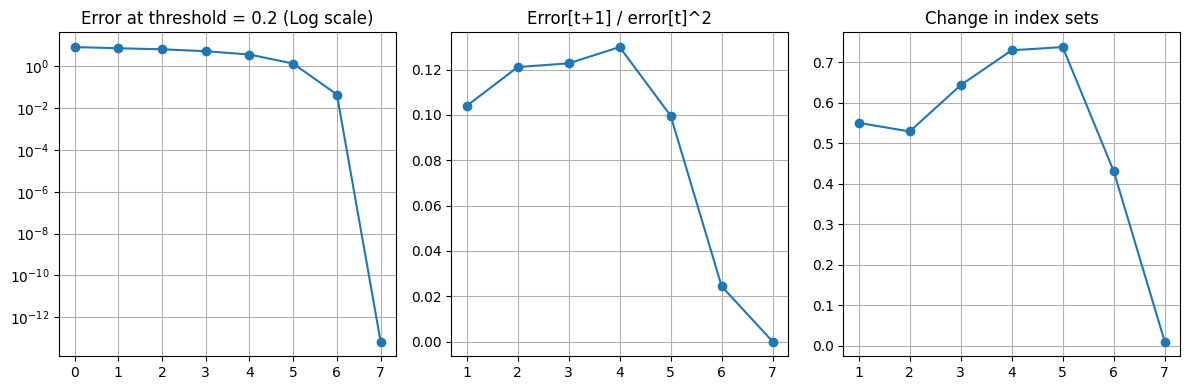

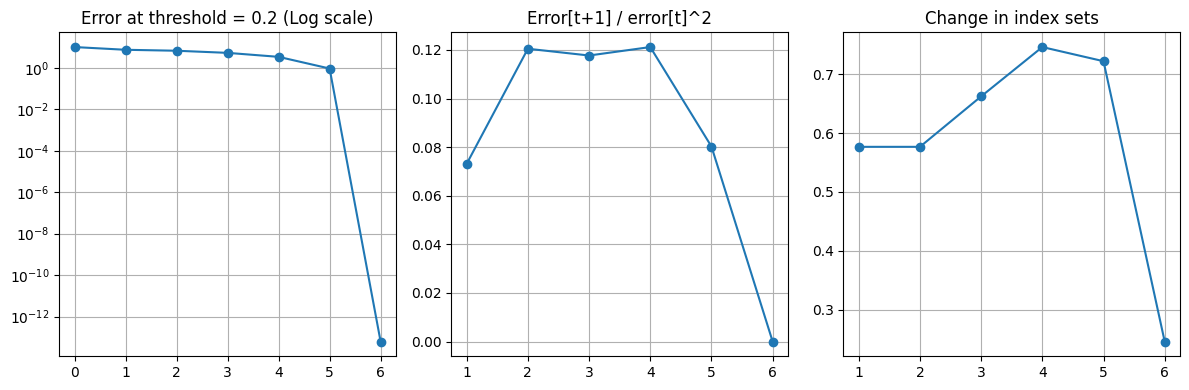

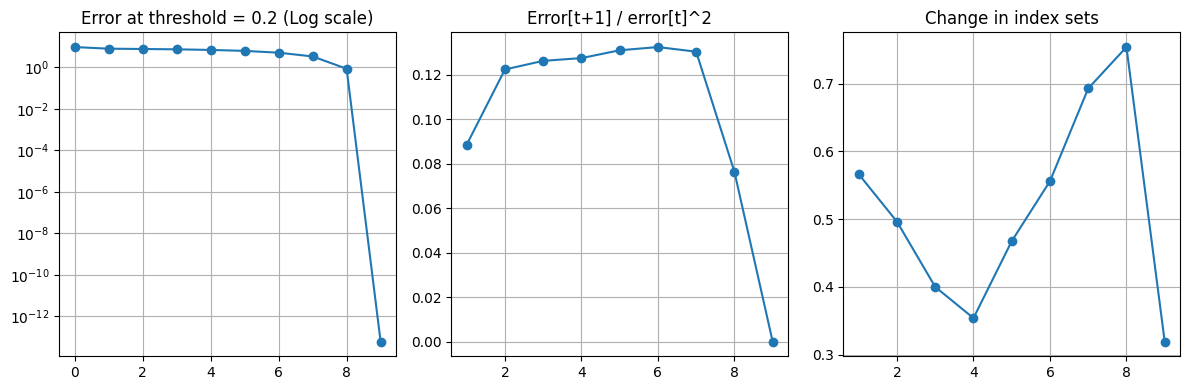

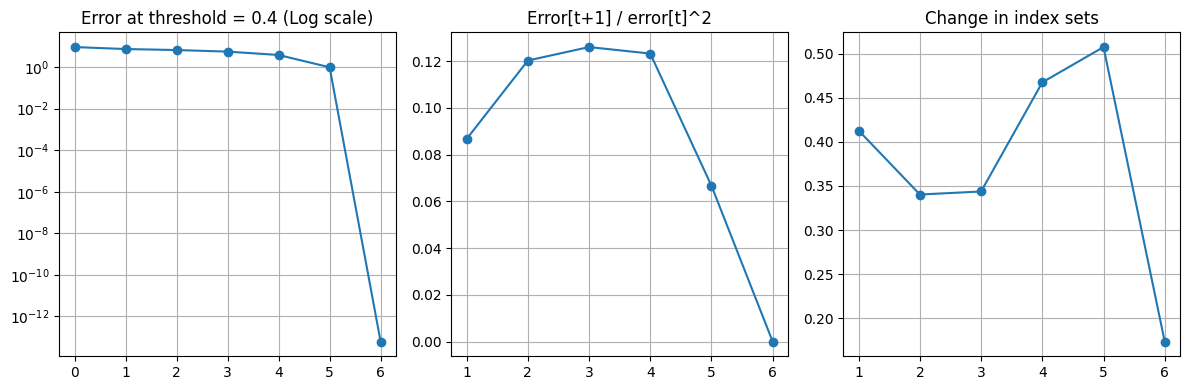

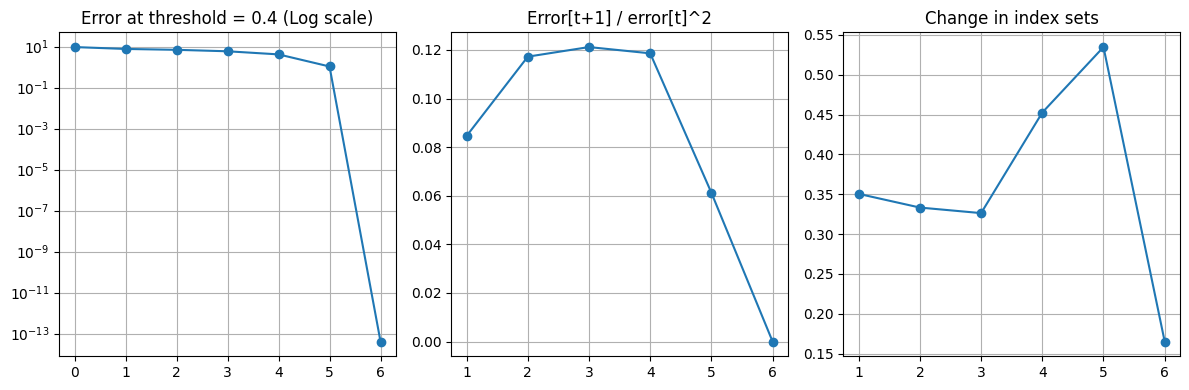

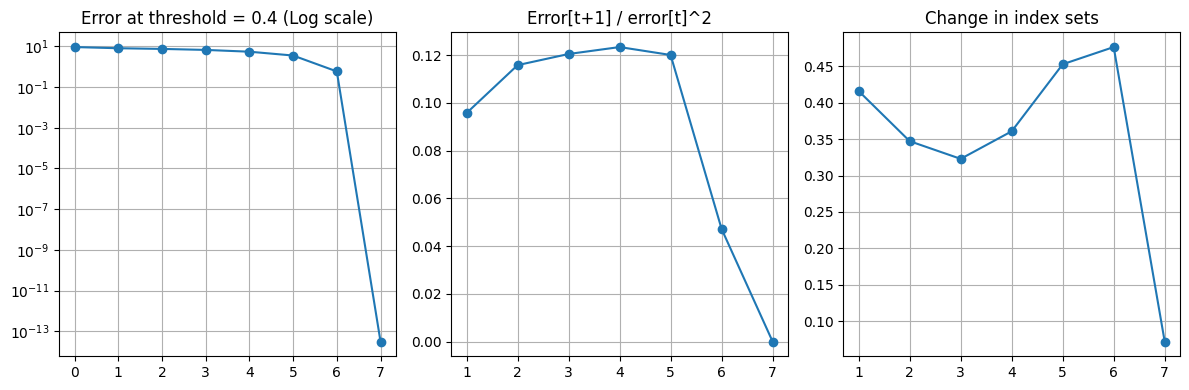

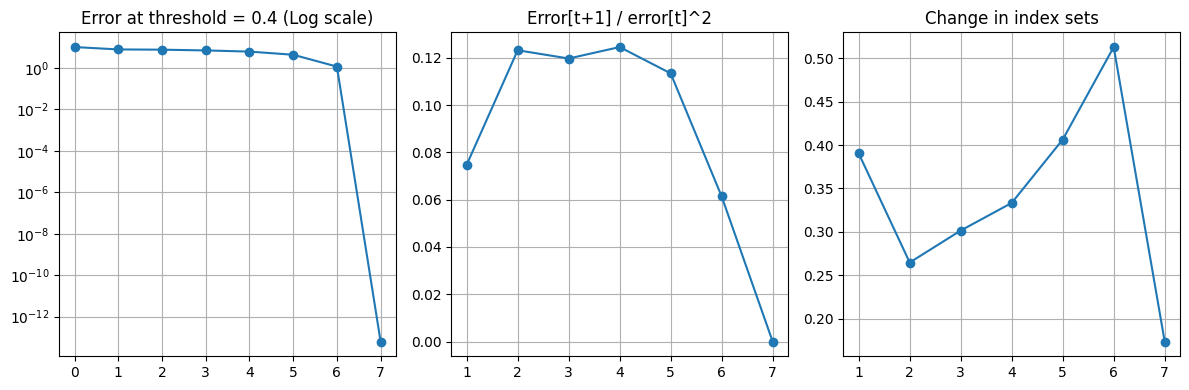

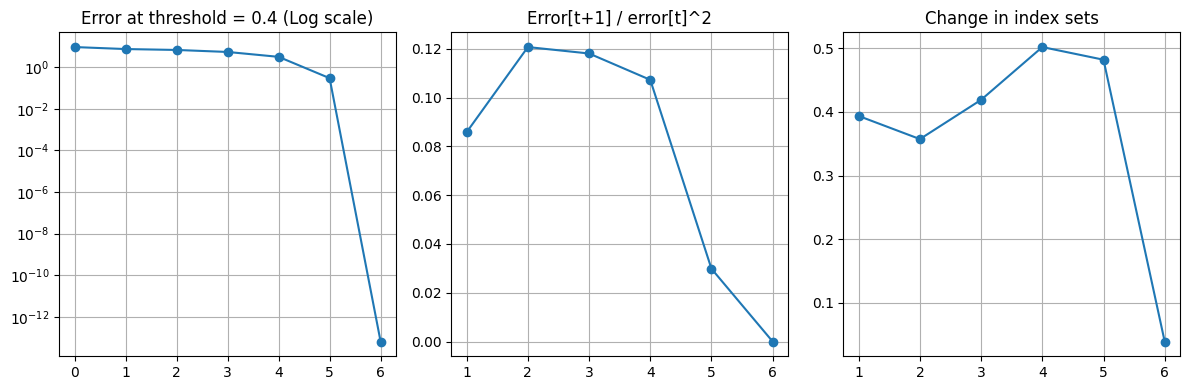

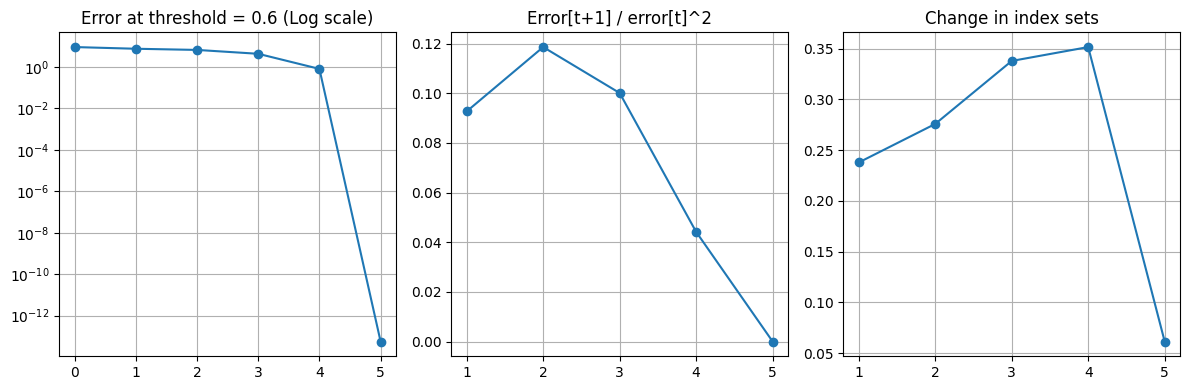

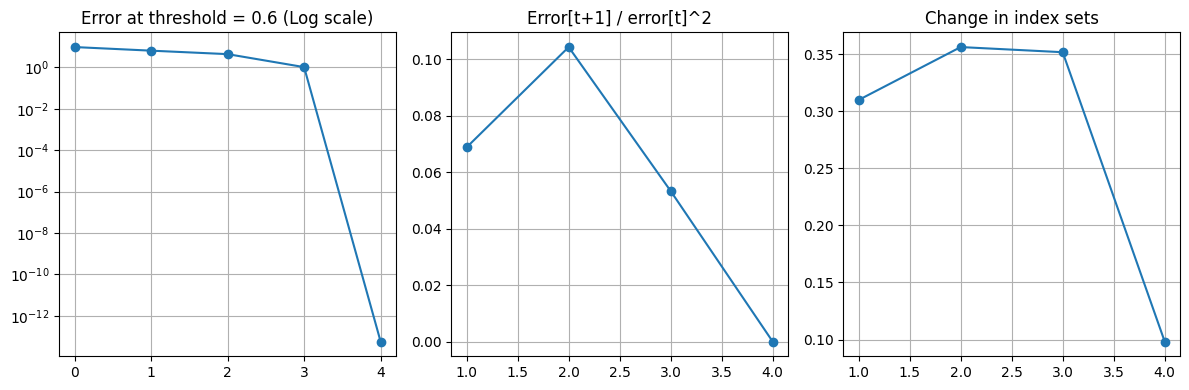

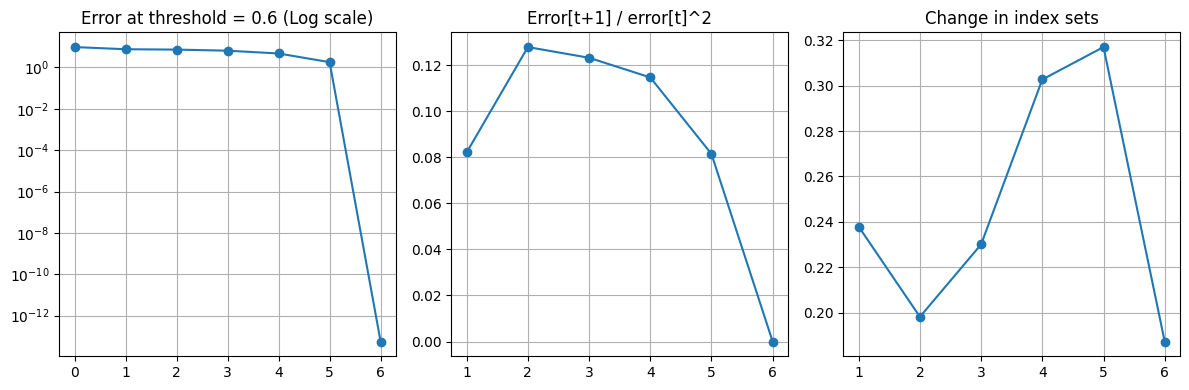

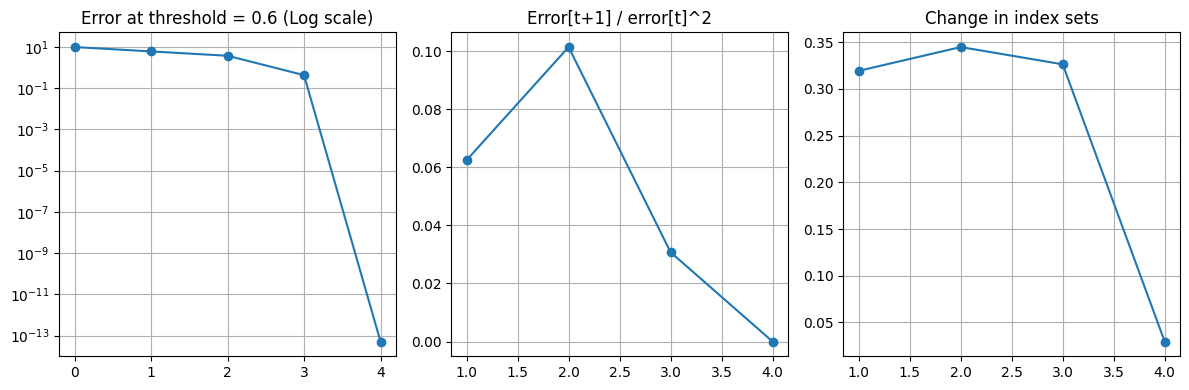

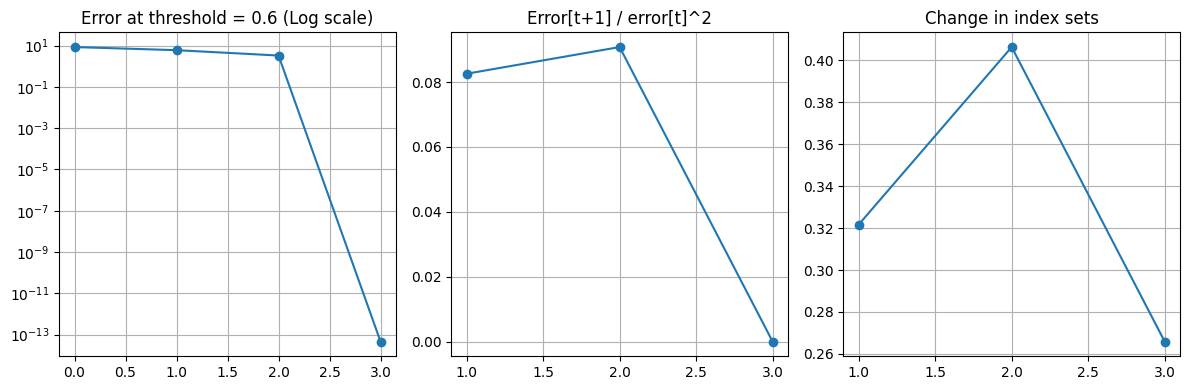

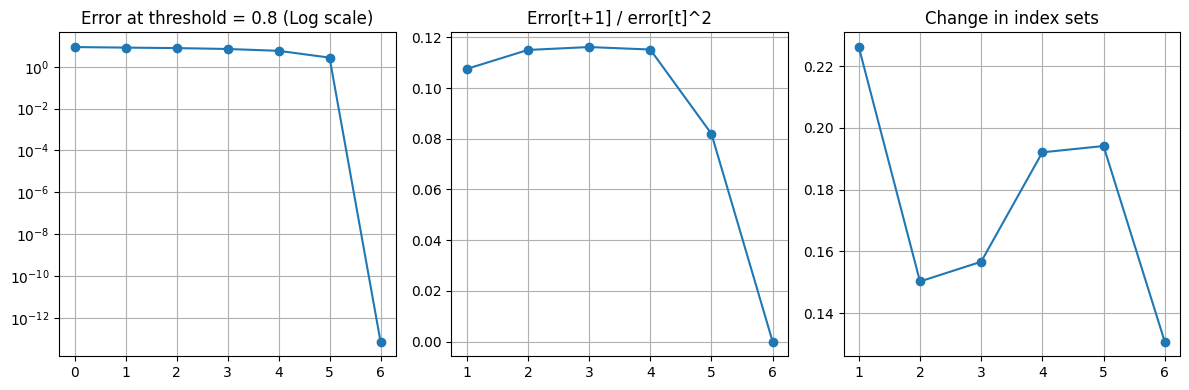

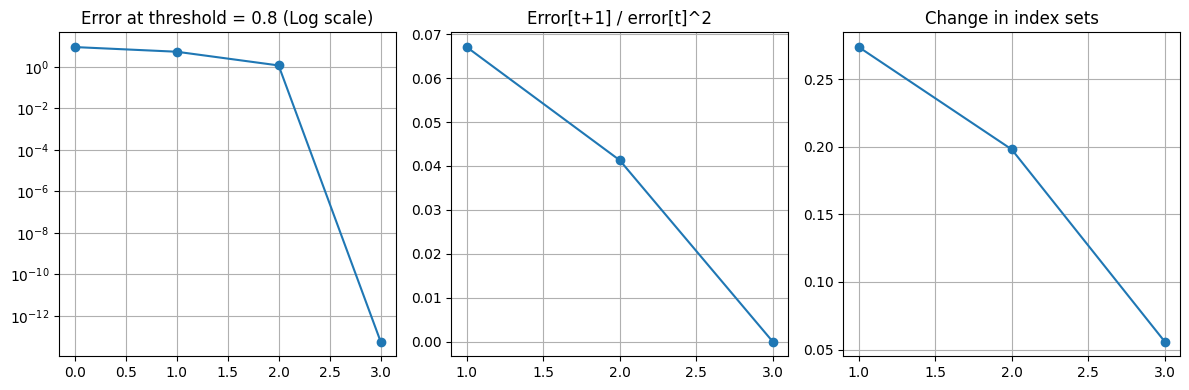

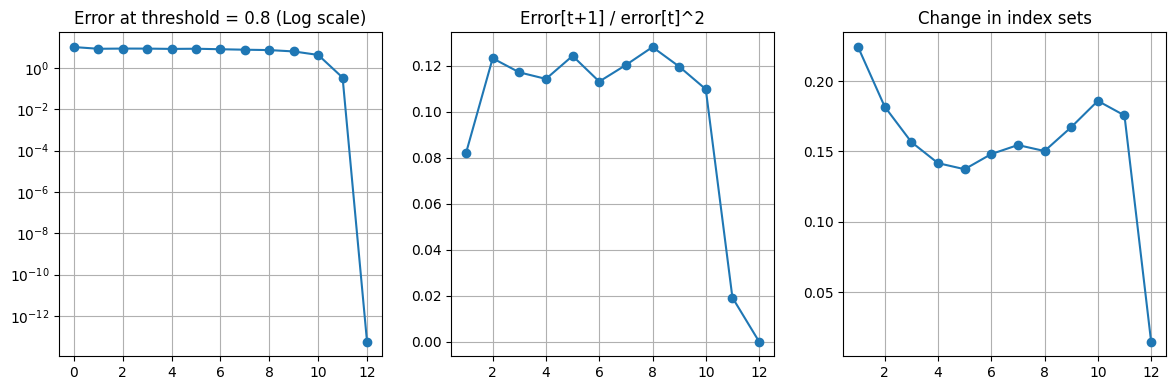

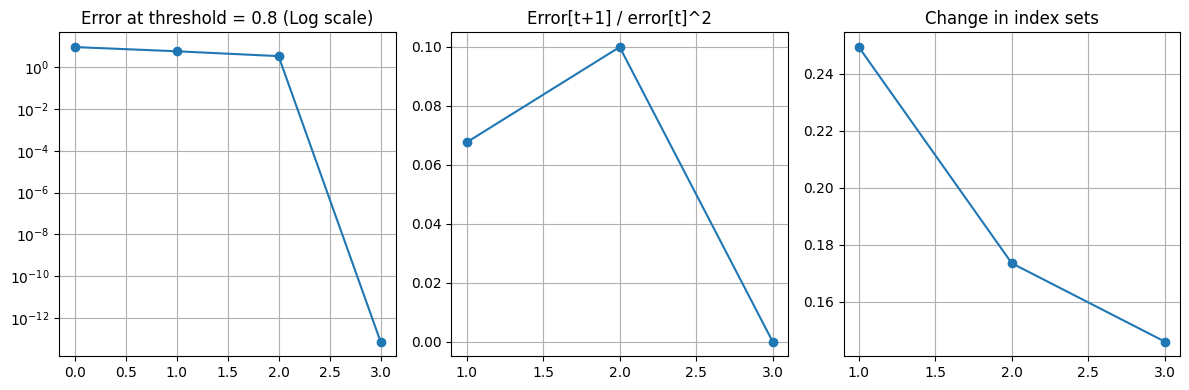

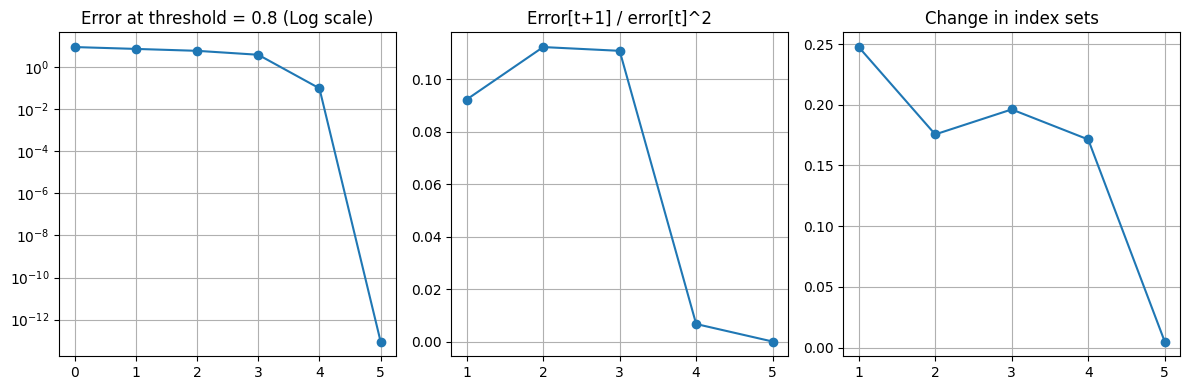

In [202]:
for threshold in [0.2, 0.4, 0.6, 0.8]:
    for i in range(5):
        n = 1000
        d = 50
        A = np.random.randn(d, n)
        x = np.ones(d)
        y = np.square(A.T @ x)
        x_hat,  threshold_indices= bwgd_discard_iter_test_threshold(y, A, threshold)
        
        # Errors
        error = min_error(x_hat, x)
        ratios = [error[t+1] / error[t]**2 for t in range(len(error)-1)]
        
        # Threshold indices 
        t_percent = []
        for t in range(len(threshold_indices) - 1):
            # Turn arrays into sets
            set0 = set(threshold_indices[t])
            set1 = set(threshold_indices[t+1])
        
            # Calculate percent difference
            difference = len(set0.symmetric_difference(set1))
            total = len(set0.union(set1))
            t_percent.append(difference/total)
        
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 2 columns
        
        # Plot the regular errors (log scale)
        axs[0].plot(error, marker='o')
        axs[0].set_yscale('log')  # Log scale for error
        axs[0].set_title(f'Error at threshold = {threshold} (Log scale)')
        axs[0].grid(True)
        
        # Plot the ratios
        axs[1].plot(range(1, len(t_percent)+1), ratios, marker='o')
        axs[1].set_title('Error[t+1] / error[t]^2')
        axs[1].grid(True)
        
        # Plot the Index sets
        axs[2].plot(range(1, len(t_percent)+1), t_percent, marker='o')
        axs[2].set_title('Change in index sets')
        axs[2].grid(True)
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

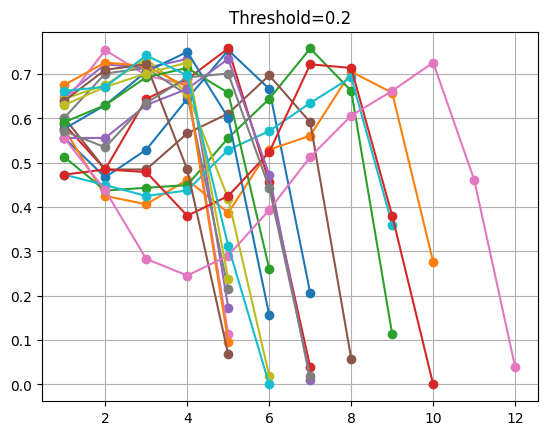

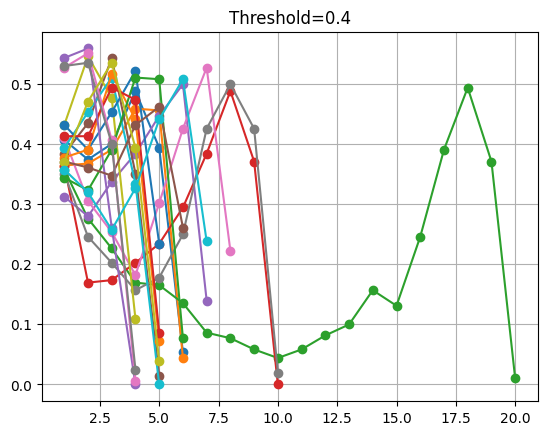

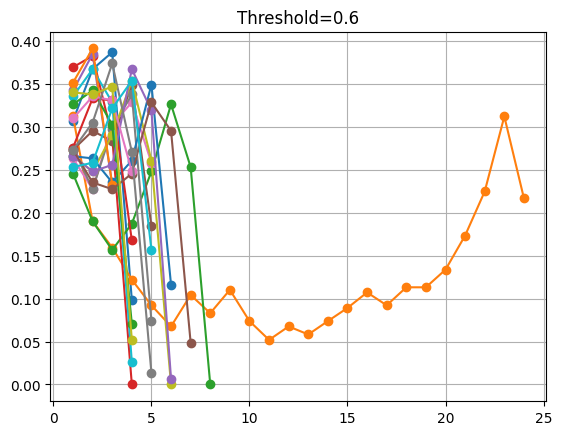

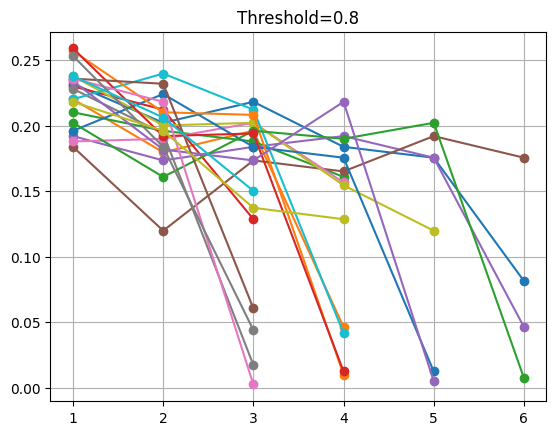

In [281]:
n = 1000
d = 50
x_true = np.ones(d)
thresholds =  [0.2, .4, .6, .8]

# Iterate through thesholds
for threshold in thresholds:
    for i in range(20):
        A = np.random.randn(d, n)
        x = np.ones(d)
        y = np.square(A.T @ x)
        x_hat,  threshold_indices= bwgd_discard_iter_test_threshold(y, A, threshold)
        
        # Errors
        error = min_error(x_hat, x)
        ratios = [error[t+1] / error[t]**2 for t in range(len(error)-1)]
        
        # Threshold indices 
        t_percent = []
        for t in range(len(threshold_indices) - 1):
            # Turn arrays into sets
            set0 = set(threshold_indices[t])
            set1 = set(threshold_indices[t+1])
        
            # Calculate percent difference
            difference = len(set0.symmetric_difference(set1))
            total = len(set0.union(set1))
            t_percent.append(difference/total)
        plt.plot(range(1, len(t_percent)+1), t_percent, marker='o')
    plt.title(f'Threshold={threshold}')
    plt.grid(True)
    plt.show()
    

**Initialize close to true value**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv

def bwgd_discard_iter_epsilon(y, A, alpha, epsilon=1, eta=1, niter=40, tol=1e-11):
    d, n = A.shape  
    x = np.zeros((niter, d))
    e = np.random.normal(0, epsilon, size=d)
    x_true = np.ones(d)
    x[0] = x_true + e  # Initialize x close to x_true with noise

    threshold = int(alpha * n)

    # Descent
    for iter in range(1, niter):
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered 
        x_tilde = C_sqrt @ x[iter - 1]

        sum_gradient = A_tilde @ (np.sqrt(y_filtered) * (A_tilde.T @ x_tilde) / np.abs(A_tilde.T @ x_tilde))
        x_tilde = (1 - eta) * x_tilde + (eta / n) * sum_gradient

        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x_true) < tol or np.linalg.norm(x[iter] - x_true*-1) < tol:
            return 1, iter 
            
    return 0, niter  

In [282]:
n = 300
d = 50
alphas = np.arange(0, 10) * 0.1  
epsilons = [1, 2, 4, 6, 8, 10]
iterations_to_converge = np.zeros((len(epsilons), len(alphas)))
convergences = np.zeros((len(epsilons), len(alphas)))

for i, epsilon in tqdm(enumerate(epsilons)):
    for j, alpha in enumerate(alphas):
        results = []
        convergence = 0
        for _ in range(100):
            A = np.random.randn(d, n)
            y = np.square(A.T @ np.ones(d))
            converged, iter = bwgd_discard_iter_epsilon(y, A, alpha,  epsilon=epsilon)
            convergence += converged
            results.append(iter)
        convergences[i, j] = convergence 
        iterations_to_converge[i, j] = np.mean(results)  # Take the mean over 100 runs


0it [00:00, ?it/s]C:\Users\gabreu\AppData\Local\Temp\ipykernel_8\3280378697.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  x[iter] = C_inv @ x_tilde
6it [03:49, 38.25s/it]


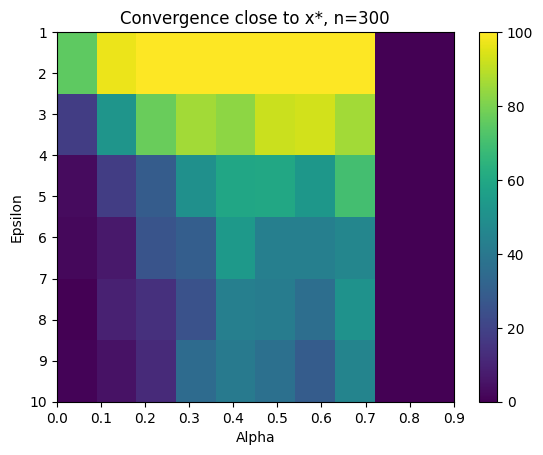

array([[ 75.,  97., 100., 100., 100., 100., 100., 100.,   0.,   0.],
       [ 18.,  52.,  77.,  86.,  83.,  92.,  93.,  86.,   0.,   0.],
       [  3.,  18.,  29.,  50.,  59.,  60.,  53.,  70.,   0.,   0.],
       [  2.,   7.,  26.,  30.,  54.,  43.,  43.,  46.,   0.,   0.],
       [  0.,   9.,  14.,  25.,  43.,  42.,  36.,  51.,   0.,   0.],
       [  1.,   5.,  12.,  35.,  41.,  37.,  29.,  45.,   0.,   0.]])

In [288]:
plt.imshow(convergences, extent=[alphas[0],alphas[-1], epsilons[-1],epsilons[0]], aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('Epsilon')
plt.title('Convergence close to x*, n=300')
plt.show()
convergences

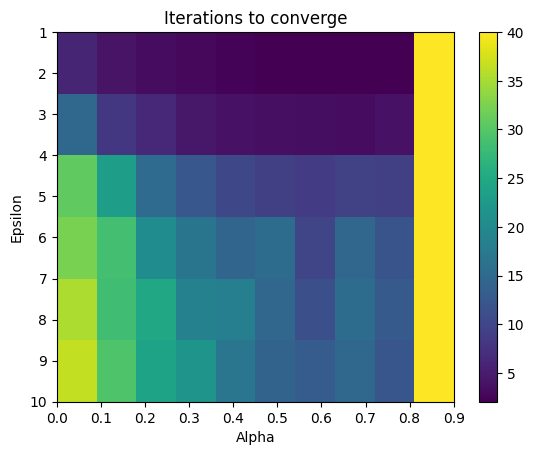

array([[ 6.02,  4.02,  3.25,  2.91,  2.47,  2.12,  2.1 ,  2.04,  2.06,
        40.  ],
       [14.82,  8.17,  6.32,  4.53,  3.84,  3.6 ,  3.49,  3.36,  3.9 ,
        40.  ],
       [30.76, 23.29, 15.37, 12.33, 10.31,  9.26,  8.6 ,  9.41,  9.19,
        40.  ],
       [32.36, 28.66, 20.51, 16.74, 14.37, 15.39, 10.  , 14.54, 11.87,
        40.  ],
       [35.34, 28.4 , 24.62, 18.68, 18.46, 14.59, 11.26, 15.42, 12.81,
        40.  ],
       [36.52, 29.53, 24.04, 21.69, 17.  , 14.09, 13.07, 14.77, 12.13,
        40.  ]])

In [284]:
plt.imshow(iterations_to_converge, extent=[alphas[0],alphas[-1], epsilons[-1],epsilons[0]], aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('Epsilon')
plt.title('Iterations to converge')
plt.show()
iterations_to_converge

0it [00:00, ?it/s]C:\Users\gabreu\AppData\Local\Temp\ipykernel_8\3280378697.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  x[iter] = C_inv @ x_tilde
6it [08:28, 84.82s/it]


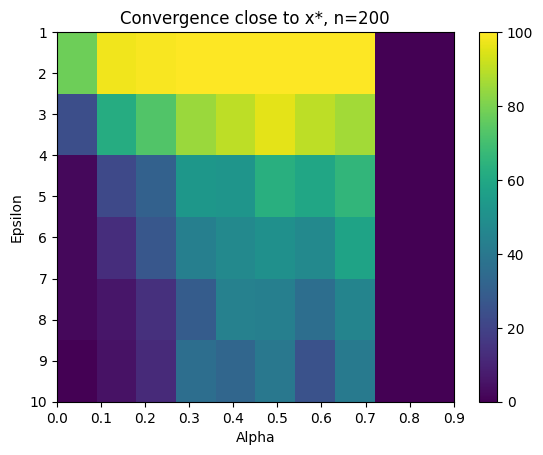

array([[ 78.,  98.,  99., 100., 100., 100., 100., 100.,   0.,   0.],
       [ 24.,  62.,  73.,  85.,  90.,  96.,  90.,  86.,   0.,   0.],
       [  2.,  22.,  31.,  53.,  52.,  63.,  59.,  66.,   0.,   0.],
       [  2.,  13.,  27.,  43.,  47.,  50.,  47.,  58.,   0.,   0.],
       [  2.,   6.,  14.,  29.,  44.,  43.,  36.,  45.,   0.,   0.],
       [  0.,   5.,  12.,  36.,  33.,  40.,  25.,  41.,   0.,   0.]])

In [289]:
n = 200
d = 50
alphas = np.arange(0, 10) * 0.1  
epsilons = [1, 2, 4, 6, 8, 10]
iterations_to_converge = np.zeros((len(epsilons), len(alphas)))
convergences = np.zeros((len(epsilons), len(alphas)))

for i, epsilon in tqdm(enumerate(epsilons)):
    for j, alpha in enumerate(alphas):
        results = []
        convergence = 0
        for _ in range(100):
            A = np.random.randn(d, n)
            y = np.square(A.T @ np.ones(d))
            converged, iter = bwgd_discard_iter_epsilon(y, A, alpha,  epsilon=epsilon)
            convergence += converged
            results.append(iter)
        convergences[i, j] = convergence 
        iterations_to_converge[i, j] = np.median(results)  # Take the median over 100 runs
        
plt.imshow(convergences, extent=[alphas[0],alphas[-1], epsilons[-1],epsilons[0]], aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('Epsilon')
plt.title('Convergence close to x*, n=200')
plt.show()
convergences